In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax

# loading data
cc_codes = ["fr"]
filename_pattern_test = "data/multilingual_train/test_full_week_{}_non_anon_processed.csv".format("_".join(cc_codes))
test_df = pd.read_csv(filename_pattern_test)

In [ ]:
test_df.head()

,wiki_db,event_comment,event_user_text_historical,event_user_seconds_since_previous_revision,revision_id,page_title,page_revision_count,revision_text_bytes_diff,revision_is_identity_reverted,event_timestamp,...,change_s_0_mean,change_s_1_mean,change_p_0_mean,change_p_1_mean,title_s_0,title_p_0,comment_s_0,comment_s_1,comment_p_0,comment_p_1
0,ukwiki,вилучив додаткові пробіли,HutheMeow,575.0,36399189,Grand_Theft_Auto:_Liberty_City_Stories,63,-2,0,2022-07-01 01:55:08.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.782928,1.0,0.014682,-0.198847,0.55318,0.44682
1,ukwiki,[[Help:Cat-a-lot|Cat-a-lot]]: Removing from [[...,Mr.Rosewater,0.0,36399416,Елізабет_Філпот,7,-62,0,2022-07-01 03:52:18.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.293543,1.0,0.014682,-0.198847,0.55318,0.44682
2,ukwiki,додано [[Категорія:Убиті на дуелі]] за допомог...,Mr.Rosewater,445.0,36399659,Еварист_Галуа,140,50,0,2022-07-01 04:35:09.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.076811,1.0,0.014682,-0.198847,0.55318,0.44682
3,ukwiki,"Уточнення щодо розташування, та додаткова інфо...",Ostwik,133803613.0,36400077,Парк_«Чонок»,5,284,0,2022-07-01 05:31:15.0,...,2.511288,-2.375829,0.992513,0.007487,0.836785,1.0,0.014682,-0.198847,0.55318,0.44682
4,ukwiki,NaN,Вальдимар,60.0,36400917,Кабалуд,22,-447,0,2022-07-01 07:44:57.0,...,1.986099,-1.732105,0.976298,0.023702,0.192396,1.0,-1.000000,-1.000000,-1.00000,-1.00000


In [ ]:
test_df.wiki_db.value_counts()

enwiki    695938
dewiki    108282
eswiki     92159
ruwiki     83236
plwiki     28168
ukwiki     28024
Name: wiki_db, dtype: int64

In [ ]:
len(test_df)

1035807

In [ ]:
 # 'Text_change',
 # 'Text_insert',
 # 'Text_move',
 # 'Text_remove',
 # 'Text Formatting_change',
 # 'Text Formatting_insert',
 # 'Text Formatting_move',
 # 'Text Formatting_remove',

# test_df[test_df['Text Formatting_remove'] != 0]

In [ ]:
def is_text_change(df):
    result_list = []
    for i, row in tqdm(df.iterrows()):
        key = False
        for col in ['texts_removed', 'texts_insert', 'texts_change']:
            if ast.literal_eval(row[col]).get("Text", []) != []:
                key = True
        result_list.append(key)
    return result_list

test_df["text_changes_found"] = is_text_change(test_df)

1035807it [03:03, 5630.78it/s]


In [ ]:
# rate of revisions with chenges in text
test_df.text_changes_found.mean()

0.5335318259096531

In [ ]:
# also the rate of reverts is different
test_df.groupby("text_changes_found").revision_is_identity_reverted.mean()

text_changes_found
False    0.062413
True     0.092446
Name: revision_is_identity_reverted, dtype: float64

In [ ]:
# also the rate of reverts is different
test_df.groupby(["wiki_db", "text_changes_found"])[['revision_is_identity_reverted']].agg(["mean", "count"])

revision_is_identity_reverted        
                                                    mean   count
wiki_db text_changes_found                                      
dewiki  False                                   0.030011   44251
        True                                    0.051506   64031
enwiki  False                                   0.061051  337388
        True                                    0.094059  358550
eswiki  False                                   0.108070   40224
        True                                    0.151227   51935
plwiki  False                                   0.039487   13498
        True                                    0.066326   14670
ruwiki  False                                   0.085306   35437
        True                                    0.097638   47799
ukwiki  False                                   0.026429   12373
        True                                    0.036547   15651

In [ ]:
features_list = [
       'wiki_db',
       # 'page_title', 
       'page_revision_count', 
       'revision_text_bytes_diff',
       'is_mobile_edit', 'is_mobile_web_edit',
       'is_visualeditor', 'is_wikieditor',
       'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
       # 'texts_removed', 'texts_insert', 'texts_change', 'actions',
       # 'categories', 'wikidata_item_id', 
       'page_region', 'country_iso_code',
       'region_iso_code', 'city', 'latitude', 'longitude',
       'Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove'
] \
+ [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]] \
+ [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]] \
+ [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]] \
+ [f"title_{c}" for c in ["s_0", "p_0"]]

target_column = 'revision_is_identity_reverted'
features = features_list
cat_features = [
    'wiki_db',
    # 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
    'page_region', 'country_iso_code',
    'region_iso_code', 'city'
]

# Modeling:

In [ ]:
model = CatBoostClassifier().load_model("initial_model")

# Hold-out validation

- actions features 0.6823 ->  0.7091 (baseline)


In [ ]:
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

In [ ]:
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.278790312080519,
 'AUC': 0.816016236643078,
 'Precision': 0.3658102909205108,
 'Recall': 0.443338861249309,
 'F1': 0.40086037876967506,
 'Accuracy': 0.9244169448248776}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,954562.0,0.332246,0.179870,0.001813,0.203232,0.299915,0.438642,0.996852
1,81245.0,0.577757,0.237961,0.008934,0.384546,0.579834,0.765263,0.999883


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

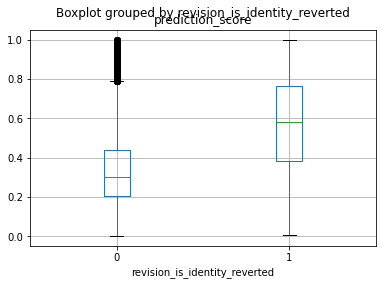

In [ ]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


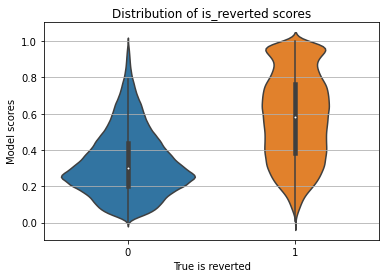

In [ ]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

# Balanced hold-out

In [ ]:
hold_out_data = Pool(
    data=test_df[test_df.is_balanced == 1][features].fillna(-1),
    label=test_df[test_df.is_balanced == 1][target_column],
    cat_features=cat_features
)
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.576571270970826,
 'AUC': 0.7753213612266736,
 'Precision': 0.7949902798629808,
 'Recall': 0.6042710320635116,
 'F1': 0.6866331439291588,
 'Accuracy': 0.6976145267808347}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,81245.0,0.346744,0.176603,0.002534,0.219307,0.313009,0.450673,0.995861
1,81245.0,0.577757,0.237961,0.008934,0.384546,0.579834,0.765263,0.999883


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


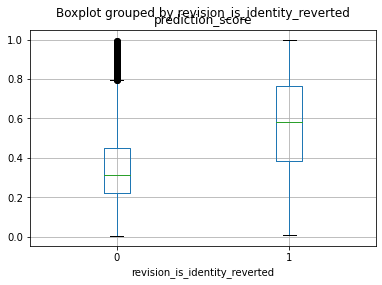

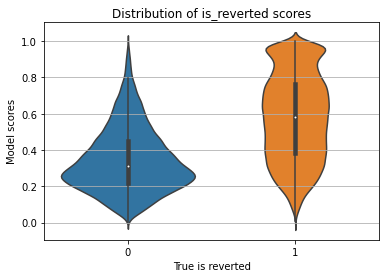

In [ ]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[test_df.is_balanced == 1][target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

## Analyzing performance per country:

In [ ]:
wikidbs = ['frwiki']
results = []
for wbd in wikidbs:

    hold_out_data = Pool(
        data=test_df[(test_df.wiki_db == wbd)][features].fillna(-1),
        label=test_df[(test_df.wiki_db == wbd)][target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    results.append(metrics_holdout)


print("Results on imbalanced data")
res_table = pd.DataFrame(results)
res_table["wiki_db"] = wikidbs
revert_rate = test_df.groupby("wiki_db")[target_column].mean().to_dict()
res_table["original_revert_rate"] = res_table["wiki_db"].apply(lambda x: revert_rate.get(x))
res_table

Results on imbalanced data


,Logloss,AUC,Precision,Recall,F1,Accuracy,wiki_db,original_revert_rate
0,0.522463,0.771930,0.233796,0.611067,0.338197,0.777170,enwiki,0.078057
1,0.176630,0.829108,0.486877,0.307008,0.376566,0.960694,ukwiki,0.032080
2,0.458896,0.810198,0.332460,0.654226,0.440878,0.817552,ruwiki,0.092388
3,0.522303,0.792186,0.357612,0.662651,0.464531,0.761303,eswiki,0.132391
4,0.244543,0.804953,0.391058,0.374406,0.382551,0.937906,dewiki,0.042722


In [ ]:
wikidbs = ["frwiki"]
results = []
for wbd in wikidbs:

    hold_out_data = Pool(
        data=test_df[(test_df.is_balanced == 1) & (test_df.wiki_db == wbd)][features].fillna(-1),
        label=test_df[(test_df.is_balanced == 1) & (test_df.wiki_db == wbd)][target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    results.append(metrics_holdout)


print("Results on balanced data")
res_table = pd.DataFrame(results)
res_table["wiki_db"] = wikidbs
revert_rate = test_df.groupby("wiki_db")[target_column].mean().to_dict()
res_table["original_revert_rate"] = res_table["wiki_db"].apply(lambda x: revert_rate.get(x))
res_table

Results on balanced data


,Logloss,AUC,Precision,Recall,F1,Accuracy,wiki_db,original_revert_rate
0,0.575492,0.771864,0.781790,0.611067,0.685966,0.693264,enwiki,0.078057
1,0.771329,0.835150,0.971010,0.307008,0.466516,0.615049,ukwiki,0.032080
2,0.532930,0.811349,0.834141,0.654226,0.733309,0.739115,ruwiki,0.092388
3,0.548458,0.794875,0.788360,0.662651,0.720060,0.717524,eswiki,0.132391
4,0.699346,0.804598,0.930085,0.374406,0.533893,0.641594,dewiki,0.042722


Random model: ROC AUC=0.501
Catboost: ROC AUC=0.788


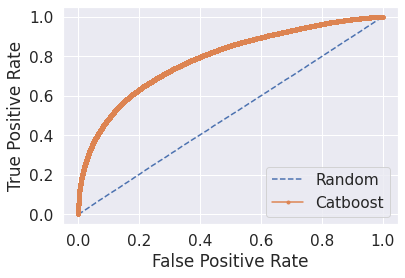

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



testy = test_df[target_column].values
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

lr_probs = model.predict_proba(hold_out_data)[:, 1]
ns_probs = [np.random.uniform() for _ in range(len(testy))]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
# summarize scores
print('Random model: ROC AUC=%.3f' % (ns_auc))
print('Catboost: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Catboost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Catboost: f1=0.330 auc=0.360


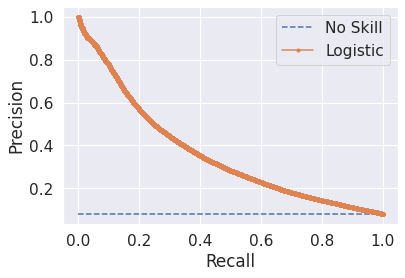

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict class values
yhat = model.predict(hold_out_data)
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Catboost: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

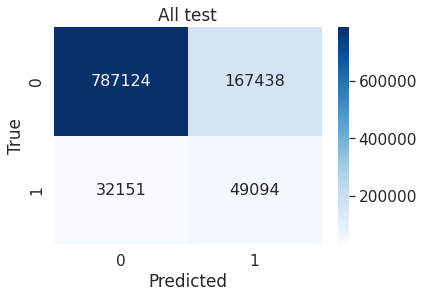

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm_anonymous = confusion_matrix(testy, yhat)

df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g') # font size
plt.title("All test")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 1. Train models for different feature sets

# 2. Make validation based on classic metrics (all wikidbs and separately)

# 3. Compare performance with Diego's model and ORES

# 4. Plot confusion matrix per algorithm / wikibd / featureset

# 5. Plot precision-recall curve per algorithm / wikibd / featureset

# 6. Calculate metrics for each day, look how they differ

# 7. Define the features that we have already have (optional)

# 1.Train models for different feature sets

In [ ]:
# loading data
cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_train = "data/multilingual_train/processed_train_{}.csv".format("_".join(cc_codes))
train_df = pd.read_csv(filename_pattern_train)
train_df = train_df[train_df["is_text_train"] == 0]


# defining featuresets
features_basic = [
    'wiki_db'
]

features_revision_1 = ['page_revision_count', 'revision_text_bytes_diff']
features_revision_2 = [
    'is_mobile_edit', 'is_mobile_web_edit', 'is_visualeditor', 
    'is_wikieditor', 'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
]
features_page_region = ['page_region']
features_user_region = ['country_iso_code', 'region_iso_code', 'city', 'latitude', 'longitude']
features_actions = [
    'Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove'
]
features_inserts = [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
features_change = [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]]
features_comment = [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]]
features_title = [f"title_{c}" for c in ["s_0", "p_0"]]

target_column = 'revision_is_identity_reverted'
cat_features_all = [
    'wiki_db', 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
    'page_region', 'country_iso_code',
    'region_iso_code', 'city'
]

def create_feature_set(list_of_lists_of_features, cat_features):
    features_list = []
    for ls in list_of_lists_of_features:
        features_list += ls
    cat_features = [c for c in cat_features if c in features_list]
    return features_list, cat_features


# setup
def get_metrics_by_feature_set(list_of_lists_of_features, cat_features_all=cat_features_all):
    features_list, cat_features = create_feature_set(list_of_lists_of_features, cat_features_all)
    BALANCE_CLASS_MODEL = True
    balancing_column = 'is_balanced'
    target_column = 'revision_is_identity_reverted'

    X_train, X_test, y_train, y_test = train_test_split(train_df[features_list].fillna(-1), 
                                                        train_df[target_column], 
                                                        test_size=0.1, 
                                                        random_state=42, 
                                                        stratify=train_df[target_column])
    train_data = Pool(
        data=X_train,
        label=y_train,
        cat_features=cat_features
    )
    test_data = Pool(
        data=X_test,
        label=y_test,
        cat_features=cat_features
    )
    hold_out_data = Pool(
        data=test_df[features_list].fillna(-1),
        label=test_df[target_column],
        cat_features=cat_features
    )

    ### class weighting
    if BALANCE_CLASS_MODEL:
        classes = np.unique(y_train)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
        class_weights = dict(zip(classes, weights))
    else:
        class_weights = {0: 1, 1: 1}
    #####

    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=5000, metric_period=1000, verbose=True, learning_rate=0.01, class_weights=class_weights, 
                               use_best_model=True, thread_count=15,
                               custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
    # Fit model
    model.fit(train_data, eval_set=test_data, plot=False)

    hold_out_data = Pool(
        data=test_df[features_list].fillna(-1),
        label=test_df[target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout_full = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}

    hold_out_data = Pool(
        data=test_df[test_df.is_balanced == 1][features_list].fillna(-1),
        label=test_df[test_df.is_balanced == 1][target_column],
        cat_features=cat_features
    )
    res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_holdout_balanced_full = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    
    # calculating accuracy per country
    metrics_per_country = {}
    for wikibd in test_df.wiki_db.unique():
        hold_out_data = Pool(
            data=test_df[test_df.wiki_db == wikibd][features_list].fillna(-1),
            label=test_df[test_df.wiki_db == wikibd][target_column],
            cat_features=cat_features
        )
        res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
        metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
        
        hold_out_data = Pool(
            data=test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)][features_list].fillna(-1),
            label=test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)][target_column],
            cat_features=cat_features
        )
        res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
        metrics_holdout_balanced = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
        metrics_per_country[wikibd] = (metrics_holdout, metrics_holdout_balanced)
    
    results = {
        "metrics_holdout": metrics_holdout_full,
        "metrics_holdout_balanced": metrics_holdout_balanced_full,
        "features_list": features_list,
        "metrics_per_country": metrics_per_country,
        "model": model
    }
    
    return results


feature_sets_to_test = {
"all": [features_basic, features_revision_1, features_revision_2, features_user_region, features_page_region, 
        features_actions, features_inserts, features_change, features_comment, features_title],
"no_text_features": [features_basic, features_revision_1, features_revision_2, features_user_region, features_page_region, 
        features_actions],
"no_user_and_page_location_features": [features_basic, features_revision_1, features_revision_2, 
        features_actions, features_inserts, features_change, features_comment, features_title],
"features_text_only": [features_inserts, features_change, features_comment, features_title]
}

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
results_dict = {}
for k, v in tqdm(feature_sets_to_test.items()):
    print(k)
    results_dict[k] = get_metrics_by_feature_set(v)

  0%|          | 0/4 [00:00<?, ?it/s]

all
0:	learn: 0.6905793	test: 0.6905341	best: 0.6905341 (0)	total: 298ms	remaining: 24m 48s
1000:	learn: 0.4959621	test: 0.4843848	best: 0.4843848 (1000)	total: 3m 39s	remaining: 14m 37s
2000:	learn: 0.4844776	test: 0.4720211	best: 0.4720211 (2000)	total: 7m 34s	remaining: 11m 21s
3000:	learn: 0.4782077	test: 0.4662051	best: 0.4662051 (3000)	total: 11m 31s	remaining: 7m 40s
4000:	learn: 0.4739703	test: 0.4627220	best: 0.4627220 (4000)	total: 15m 32s	remaining: 3m 52s
4999:	learn: 0.4706881	test: 0.4602345	best: 0.4602345 (4999)	total: 19m 27s	remaining: 0us

bestTest = 0.4602345412
bestIteration = 4999



 25%|██▌       | 1/4 [20:21<1:01:04, 1221.62s/it]

no_text_features
0:	learn: 0.6916797	test: 0.6915660	best: 0.6915660 (0)	total: 255ms	remaining: 21m 17s
1000:	learn: 0.5419432	test: 0.5285148	best: 0.5285148 (1000)	total: 3m 42s	remaining: 14m 47s
2000:	learn: 0.5296127	test: 0.5158693	best: 0.5158693 (2000)	total: 7m 33s	remaining: 11m 20s
3000:	learn: 0.5228518	test: 0.5095827	best: 0.5095827 (3000)	total: 11m 35s	remaining: 7m 42s
4000:	learn: 0.5184079	test: 0.5057553	best: 0.5057553 (4000)	total: 15m 47s	remaining: 3m 56s
4999:	learn: 0.5149373	test: 0.5029129	best: 0.5029129 (4999)	total: 20m 13s	remaining: 0us

bestTest = 0.5029129481
bestIteration = 4999



 50%|█████     | 2/4 [41:29<41:37, 1248.63s/it]  

no_user_and_page_location_features
0:	learn: 0.6905555	test: 0.6905150	best: 0.6905150 (0)	total: 209ms	remaining: 17m 24s
1000:	learn: 0.5169081	test: 0.5134424	best: 0.5134424 (1000)	total: 2m 31s	remaining: 10m 4s
2000:	learn: 0.5079328	test: 0.5051697	best: 0.5051697 (2000)	total: 4m 57s	remaining: 7m 25s
3000:	learn: 0.5032288	test: 0.5015431	best: 0.5015431 (3000)	total: 7m 23s	remaining: 4m 55s
4000:	learn: 0.5001808	test: 0.4994926	best: 0.4994926 (4000)	total: 9m 51s	remaining: 2m 27s
4999:	learn: 0.4977949	test: 0.4980396	best: 0.4980396 (4999)	total: 12m 22s	remaining: 0us

bestTest = 0.4980395991
bestIteration = 4999



 75%|███████▌  | 3/4 [54:14<17:08, 1028.09s/it]

features_text_only
0:	learn: 0.6908679	test: 0.6908491	best: 0.6908491 (0)	total: 62.2ms	remaining: 5m 10s
1000:	learn: 0.5724244	test: 0.5709127	best: 0.5709127 (1000)	total: 29.8s	remaining: 1m 59s
2000:	learn: 0.5707572	test: 0.5699719	best: 0.5699719 (2000)	total: 59.8s	remaining: 1m 29s
3000:	learn: 0.5694190	test: 0.5695638	best: 0.5695638 (3000)	total: 1m 30s	remaining: 1m
4000:	learn: 0.5682425	test: 0.5693251	best: 0.5693251 (4000)	total: 2m	remaining: 30s
4999:	learn: 0.5671628	test: 0.5691767	best: 0.5691767 (4999)	total: 2m 29s	remaining: 0us

bestTest = 0.569176722
bestIteration = 4999



100%|██████████| 4/4 [56:58<00:00, 854.50s/it] 


In [ ]:
# only metrics
only_metrics = {}
for k, v in tqdm(results_dict.items()):
    only_metrics[k] = results_dict[k]['metrics_holdout']

# only metrics balanced
only_metrics_b = {}
for k, v in tqdm(results_dict.items()):
    only_metrics_b[k] = results_dict[k]['metrics_holdout_balanced']

100%|██████████| 4/4 [00:00<00:00, 69905.07it/s]


# 2. Make validation based on classic metrics (all wikidbs and separately)

In [24]:
def get_metrics(featureset_name, list_of_lists_of_features):
    
    metrics_all = {}
    features_list, cat_features = create_feature_set(list_of_lists_of_features, cat_features_all)
    ############## unbalanced ###############
    hold_out_data = Pool(
        data=test_df[features_list].fillna(-1),
        label=test_df[target_column],
        cat_features=cat_features
    )
    res = results_dict[featureset_name]["model"].eval_metrics(hold_out_data, 
                                                    metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)

    metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    metrics_holdout["original_revert_rate"] = test_df[target_column].mean()
    metrics_holdout["number of records"] = len(test_df)
    metrics_all["all"] = metrics_holdout
    
    for wikibd in test_df.wiki_db.unique():
        hold_out_data = Pool(
            data=test_df[test_df.wiki_db == wikibd][features_list].fillna(-1),
            label=test_df[test_df.wiki_db == wikibd][target_column],
            cat_features=cat_features
        )
        res = results_dict[featureset_name]["model"].eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
        metrics_holdout_cc = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
        metrics_holdout_cc["original_revert_rate"] = test_df[test_df.wiki_db == wikibd][target_column].mean()
        metrics_holdout_cc["number of records"] = len(test_df[test_df.wiki_db == wikibd])
        metrics_all[wikibd] = metrics_holdout_cc
    
    ############## balanced ###############
    hold_out_data = Pool(
        data=test_df[(test_df.is_balanced == 1)][features_list].fillna(-1),
        label=test_df[(test_df.is_balanced == 1)][target_column],
        cat_features=cat_features
    )
    res = results_dict[featureset_name]["model"].eval_metrics(hold_out_data, 
                                                    metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
    metrics_all_balanced = {}
    metrics_holdout_balanced = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
    metrics_holdout_balanced["original_revert_rate"] = test_df[(test_df.is_balanced == 1)][target_column].mean()
    metrics_holdout_balanced["number of records"] = len(test_df[(test_df.is_balanced == 1)])
    metrics_all_balanced["all"] = metrics_holdout_balanced
    
    metrics_holdout_balanced_cc = {}
    for wikibd in test_df.wiki_db.unique():
        hold_out_data = Pool(
            data=test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)][features_list].fillna(-1),
            label=test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)][target_column],
            cat_features=cat_features
        )
        res = results_dict[featureset_name]["model"].eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
        metrics_holdout_balanced_cc = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
        metrics_holdout_balanced_cc["original_revert_rate"] = test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)][target_column].mean()
        metrics_holdout_balanced_cc["number of records"] = len(test_df[(test_df.wiki_db == wikibd) & (test_df.is_balanced == 1)])
        metrics_all_balanced[wikibd] = metrics_holdout_balanced_cc
    
    return metrics_all, metrics_all_balanced


In [25]:
res_metrics = {}

for key, values in tqdm(feature_sets_to_test.items()):
    res_metrics[key] = get_metrics(key, values)

100%|██████████| 4/4 [02:04<00:00, 31.00s/it]


In [26]:
print("NON BALANCED")
print("-"*50)

for key in res_metrics.keys():
    print(key)
    display(pd.DataFrame(res_metrics[key][0]).T)

NON BALANCED
--------------------------------------------------
all


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.347038,0.823201,0.377150,0.546803,0.446401,0.873031,0.078436,1035807.0
ukwiki,0.145796,0.841056,0.590350,0.295884,0.394197,0.964836,0.032080,28024.0
dewiki,0.163725,0.828413,0.628237,0.329010,0.431856,0.955524,0.042722,108282.0
plwiki,0.392025,0.804591,0.287369,0.561753,0.380229,0.882520,0.053465,28168.0
eswiki,0.431192,0.836371,0.452065,0.652651,0.534148,0.822127,0.132391,92159.0
ruwiki,0.370006,0.829681,0.431146,0.616905,0.507563,0.868386,0.092388,83236.0
enwiki,0.367535,0.812696,0.348912,0.535390,0.422489,0.863623,0.078057,695938.0


no_text_features


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.414079,0.796519,0.294477,0.568170,0.387906,0.832133,0.078436,1035807.0
ukwiki,0.176669,0.822142,0.538336,0.245829,0.337527,0.962688,0.032080,28024.0
dewiki,0.177990,0.811046,0.565605,0.289451,0.382934,0.952073,0.042722,108282.0
plwiki,0.495451,0.762159,0.188366,0.585657,0.285051,0.811536,0.053465,28168.0
eswiki,0.513395,0.805823,0.359839,0.684206,0.471635,0.760471,0.132391,92159.0
ruwiki,0.443056,0.819824,0.342753,0.651235,0.449126,0.824351,0.092388,83236.0
enwiki,0.439953,0.783092,0.272350,0.558935,0.366243,0.819764,0.078057,695938.0


no_user_and_page_location_features


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.444311,0.809252,0.284346,0.614376,0.388764,0.819135,0.078436,1035807.0
ukwiki,0.166007,0.839864,0.475433,0.328142,0.388289,0.960023,0.032080,28024.0
dewiki,0.228338,0.823942,0.396869,0.381755,0.389166,0.938430,0.042722,108282.0
plwiki,0.313493,0.850984,0.361190,0.544489,0.434291,0.909002,0.053465,28168.0
eswiki,0.488484,0.816445,0.385952,0.671338,0.490129,0.781761,0.132391,92159.0
ruwiki,0.424953,0.833419,0.352086,0.660728,0.459380,0.829012,0.092388,83236.0
enwiki,0.490437,0.794899,0.254714,0.621505,0.361339,0.795296,0.078057,695938.0


features_text_only


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.553240,0.719581,0.201148,0.563555,0.296476,0.749608,0.078436,1035807.0
ukwiki,0.377648,0.704378,0.133427,0.329255,0.189900,0.891381,0.032080,28024.0
dewiki,0.430854,0.698650,0.149929,0.384133,0.215678,0.856461,0.042722,108282.0
plwiki,0.492738,0.717244,0.172302,0.487384,0.254597,0.816920,0.053465,28168.0
eswiki,0.620464,0.721837,0.261391,0.670355,0.376122,0.652529,0.132391,92159.0
ruwiki,0.587993,0.719546,0.211136,0.600260,0.312391,0.709461,0.092388,83236.0
enwiki,0.568407,0.706211,0.193315,0.555639,0.286835,0.742560,0.078057,695938.0


In [27]:
print("BALANCED")
print("-"*50)
for key in res_metrics.keys():
    print(key)
    display(pd.DataFrame(res_metrics[key][1]).T)

BALANCED
--------------------------------------------------
all


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.586441,0.810894,0.868122,0.546803,0.670978,0.705999,0.5,162490.0
ukwiki,0.840250,0.843513,0.975817,0.295884,0.454083,0.609955,0.5,1798.0
dewiki,0.863222,0.825950,0.973130,0.329010,0.491759,0.627156,0.5,9252.0
plwiki,0.568185,0.806957,0.877744,0.561753,0.685066,0.716839,0.5,3012.0
eswiki,0.514261,0.836982,0.843865,0.652651,0.736042,0.743366,0.5,24402.0
ruwiki,0.533192,0.831067,0.885150,0.616905,0.727075,0.746088,0.5,15380.0
enwiki,0.582926,0.813791,0.866179,0.535390,0.661749,0.699934,0.5,108646.0


no_text_features


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.598352,0.781849,0.817868,0.568170,0.670528,0.693887,0.5,162490.0
ukwiki,0.817922,0.826212,0.988938,0.245829,0.393774,0.585025,0.5,1798.0
dewiki,0.880827,0.809606,0.966111,0.289451,0.445445,0.604882,0.5,9252.0
plwiki,0.598274,0.759936,0.799159,0.585657,0.675950,0.692148,0.5,3012.0
eswiki,0.541970,0.807633,0.786627,0.684206,0.731851,0.725120,0.5,24402.0
ruwiki,0.533498,0.822466,0.840537,0.651235,0.733875,0.741059,0.5,15380.0
enwiki,0.592510,0.784451,0.817154,0.558935,0.663817,0.689623,0.5,108646.0


no_user_and_page_location_features


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.557728,0.798212,0.812640,0.614376,0.699735,0.710928,0.5,162490.0
ukwiki,0.774698,0.843961,0.967568,0.328142,0.490079,0.625630,0.5,1798.0
dewiki,0.694106,0.823314,0.936630,0.381755,0.542426,0.646893,0.5,9252.0
plwiki,0.553718,0.851256,0.912854,0.544489,0.682116,0.721773,0.5,3012.0
eswiki,0.525453,0.817883,0.805711,0.671338,0.732413,0.731062,0.5,24402.0
ruwiki,0.511680,0.834921,0.845471,0.660728,0.741770,0.747790,0.5,15380.0
enwiki,0.556403,0.795365,0.800830,0.621505,0.699863,0.707752,0.5,108646.0


features_text_only


,Logloss,AUC,Precision,Recall,F1,Accuracy,original_revert_rate,number of records
all,0.625490,0.707347,0.733645,0.563555,0.637449,0.648552,0.5,162490.0
ukwiki,0.703846,0.704382,0.819723,0.329255,0.469805,0.592572,0.5,1798.0
dewiki,0.678230,0.693546,0.792686,0.384133,0.517491,0.607279,0.5,9252.0
plwiki,0.630997,0.721458,0.794782,0.487384,0.604234,0.649969,0.5,3012.0
eswiki,0.605350,0.721214,0.699945,0.670355,0.684831,0.661728,0.5,24402.0
ruwiki,0.613283,0.716742,0.720601,0.600260,0.654948,0.653249,0.5,15380.0
enwiki,0.625801,0.707351,0.739957,0.555639,0.634687,0.649329,0.5,108646.0


# 3. Compare performance with Diego's model and ORES

In [36]:
diegos_model_res = pd.read_csv("data/multilingual_train/test_fr_xgb_proba.csv")
ores_model_res = pd.read_csv("data/multilingual_train/test_fr_ores_res_non_anon.csv")

diegos_model_res_dict = {rid: score for rid, score in zip(diegos_model_res.revision_id, diegos_model_res.xgb_pred_proba)}
ores_model_res_dict = {rid: score for rid, score in zip(ores_model_res.revision_id, ores_model_res.ores_pred)}

In [37]:
hold_out_data = Pool(
    data=test_df[features_list].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

test_df["catboost_pred"] = model.predict_proba(hold_out_data)[:, 1]
test_df["ores_pred"] = test_df.revision_id.apply(lambda x: ores_model_res_dict.get(x)).fillna(-1)
test_df["xgb_pred"] = test_df.revision_id.apply(lambda x: diegos_model_res_dict.get(x)).fillna(-1)

In [46]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

threshold = 0.5

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
# df_to_plot = test_df
print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.9298523113014733
Xgboost model accuracy:  0.7857802975100858
ORES model accuracy:  0.8928590470435601
--------------------------------------------------
Catboost model AUC:  0.8178721456678228
Xgboost model AUC:  0.8626891648142363
ORES model AUC:  0.8431880726598229
--------------------------------------------------
Catboost model F1:  0.37408816999682837
Xgboost model F1:  0.2574007331423467
ORES model F1:  0.33397779373584485


In [47]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.6996043707611153
Xgboost model accuracy:  0.7837226827430294
ORES model accuracy:  0.74086284853052
--------------------------------------------------
Catboost model AUC:  0.8138974110188124
Xgboost model AUC:  0.8594397301200112
ORES model AUC:  0.8419813075367999
--------------------------------------------------
Catboost model F1:  0.5966864803338814
Xgboost model F1:  0.7844536237326323
ORES model F1:  0.6872797544617484


In [48]:
threshold = 0.5

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & ~test_df.country_iso_code.isna()]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > threshold).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.7710910200232958
Xgboost model accuracy:  0.2272449941760497
ORES model accuracy:  0.5003605302568085
--------------------------------------------------
Catboost model AUC:  0.7839921617064527
Xgboost model AUC:  0.6958087450124211
ORES model AUC:  0.6916610033797823
--------------------------------------------------
Catboost model F1:  0.5069884123760602
Xgboost model F1:  0.3251961639058414
ORES model F1:  0.37296394264235


In [49]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.text_changes_found == True)]

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))

Catboost model accuracy:  0.9297101109181646
Xgboost model accuracy:  0.7726568733280142
ORES model accuracy:  0.8868916318580748
--------------------------------------------------
Catboost model AUC:  0.8274988090140312
Xgboost model AUC:  0.8734286228089326
ORES model AUC:  0.8573676029132482
--------------------------------------------------
Catboost model F1:  0.39634555958618845
Xgboost model F1:  0.2682042501762514
ORES model F1:  0.3543489908912306


# 4. Plot confusion matrix per algorithm / wikibd / featureset

### Confusion matrix per algorithm

In [42]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true, pred, title):
    cm_anonymous = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g') # font size
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

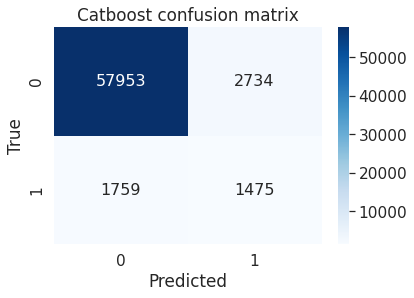

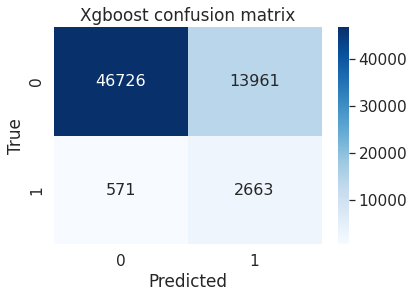

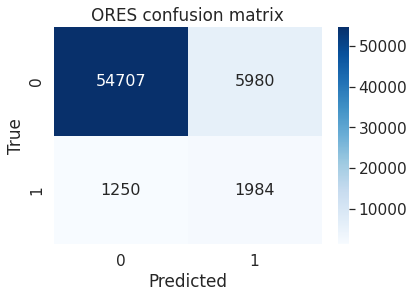

In [43]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]

true = df_to_plot.revision_is_identity_reverted
pred = (df_to_plot.catboost_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Catboost confusion matrix")

pred = (df_to_plot.xgb_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Xgboost confusion matrix")

pred = (df_to_plot.ores_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "ORES confusion matrix")

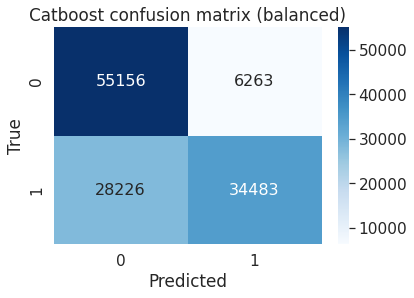

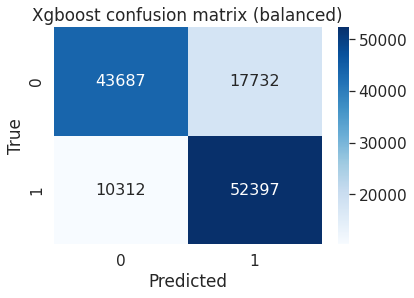

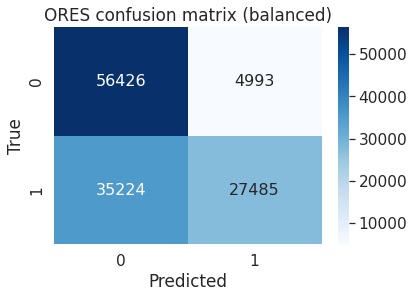

In [52]:
df_to_plot = df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]

true = df_to_plot.revision_is_identity_reverted
pred = (df_to_plot.catboost_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Catboost confusion matrix (balanced)")

pred = (df_to_plot.xgb_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "Xgboost confusion matrix (balanced)")

pred = (df_to_plot.ores_pred > 0.5).astype(int)
plot_confusion_matrix(true, pred, "ORES confusion matrix (balanced)")

### Confusion matrix per wikibd

In [53]:
def plot_confusion_matrix(df_to_plot, title=""):
    
    df_to_plot["pred"] = (df_to_plot.catboost_pred > 0.5).astype(int)
    fig, axs = plt.subplots(ncols=len(df_to_plot.wiki_db.unique()), figsize=(35, 5))
    
    for i, wiki_db in enumerate(df_to_plot.wiki_db.unique()):
        
        df_to_plot_tmp = df_to_plot[df_to_plot.wiki_db == wiki_db]
        true = df_to_plot_tmp.revision_is_identity_reverted
        pred = (df_to_plot_tmp.catboost_pred > 0.5).astype(int)
        
        cm_anonymous = confusion_matrix(true, pred)
        df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g', ax=axs[i]) # font size
        axs[i].set_title(wiki_db)
        axs[i].set_xlabel("Predicted")
        axs[i].set_ylabel("True")
    plt.show()

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


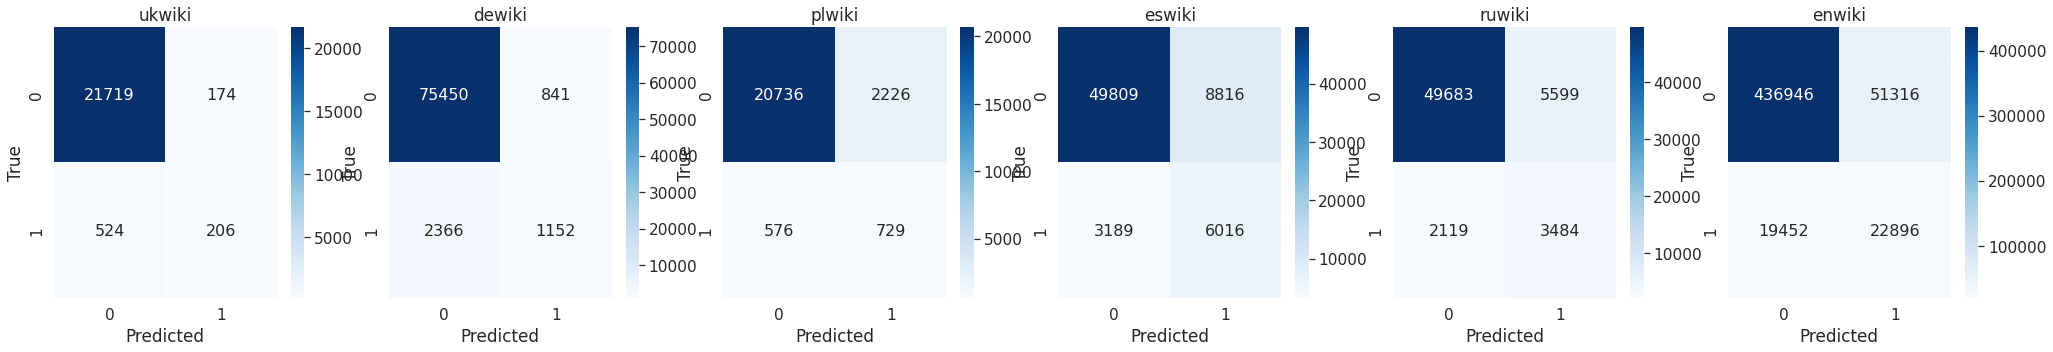

In [54]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
plot_confusion_matrix(df_to_plot)

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


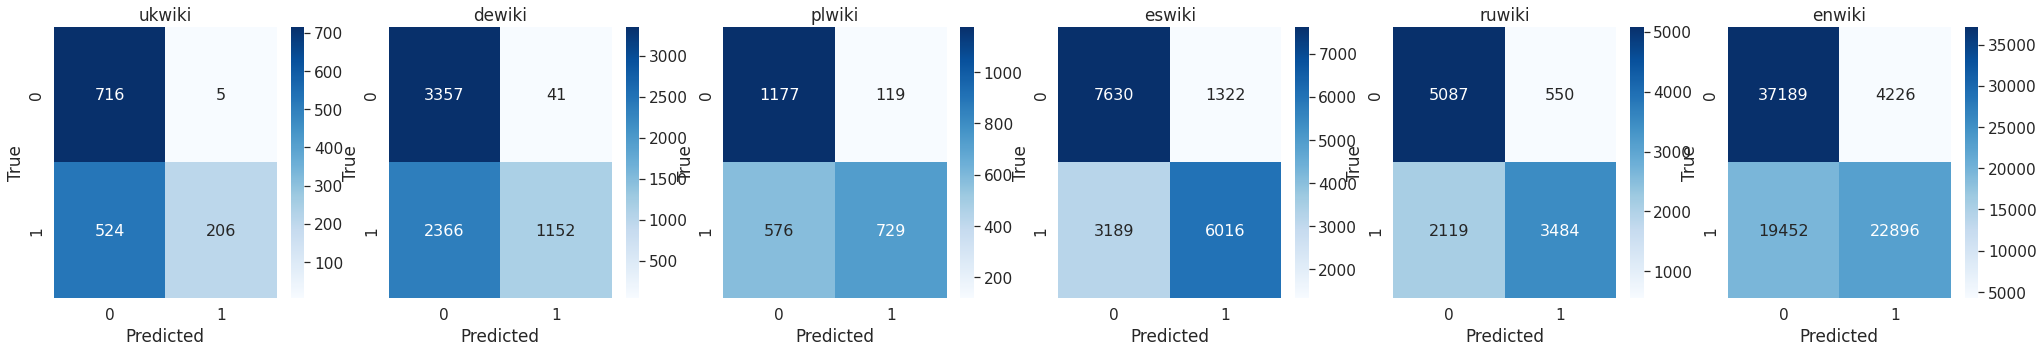

In [55]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]
plot_confusion_matrix(df_to_plot)

### Confusion matrix per feature_set

In [57]:
def plot_confusion_matrix(df_to_plot, title=""):
    
    # df_to_plot["pred"] = (df_to_plot.catboost_pred > 0.5).astype(int)
    fig, axs = plt.subplots(ncols=len(results_dict.keys()), figsize=(35, 5))
    # hold_out_data = Pool(
    #     data=test_df[features_list].fillna(-1),
    #     label=test_df[target_column],
    #     cat_features=cat_features
    # )
    for i, features in enumerate(results_dict.keys()):
        
        true = df_to_plot.revision_is_identity_reverted
        pred = results_dict[features]["model"].predict(df_to_plot[results_dict[features]["features_list"]].fillna(-1))
        
        cm_anonymous = confusion_matrix(true, pred)
        df_cm = pd.DataFrame(cm_anonymous, range(2), range(2))
        sn.set(font_scale=1.4) # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', fmt='g', ax=axs[i]) # font size
        axs[i].set_title(features)
        axs[i].set_xlabel("Predicted")
        axs[i].set_ylabel("True")
    plt.show()

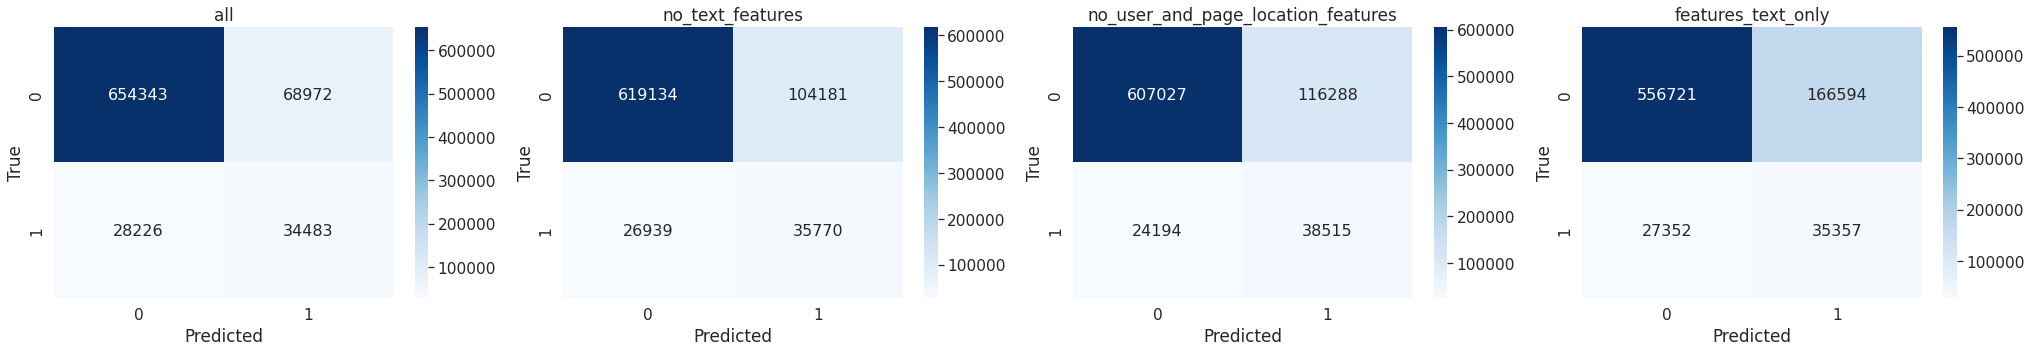

In [58]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
plot_confusion_matrix(df_to_plot, title="")

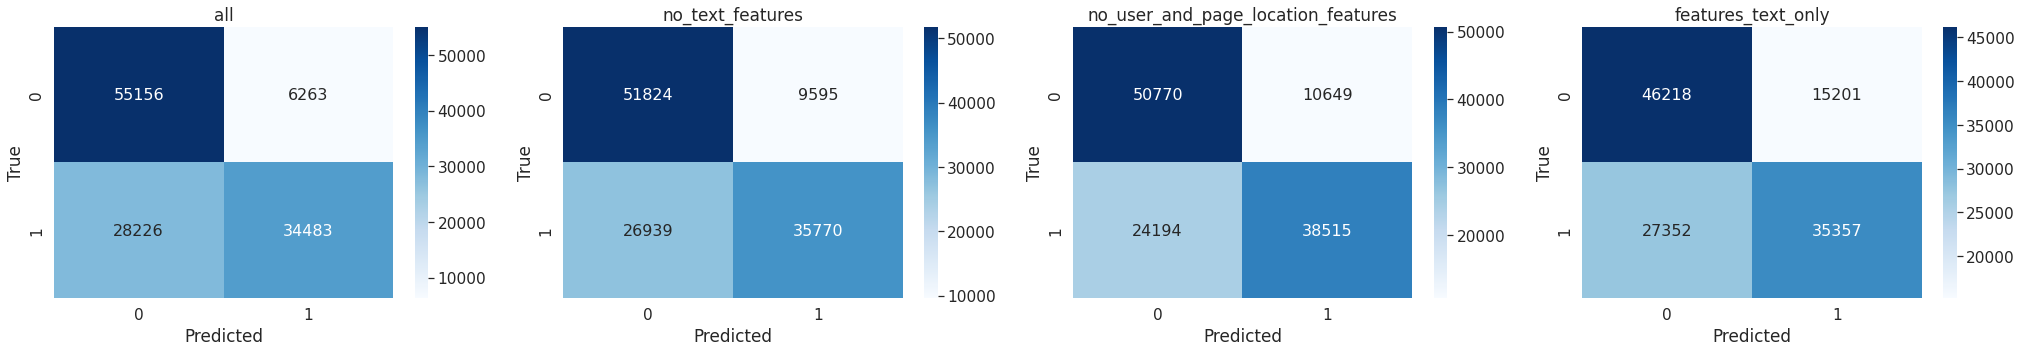

In [59]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]
plot_confusion_matrix(df_to_plot, title="")

# 5. Plot precision-recall curve per algorithm / wikibd / featureset

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from matplotlib.pyplot import figure

def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values

    catboost_probs = df_to_plot.catboost_pred.values
    ores_probs = df_to_plot.ores_pred.fillna(0).values
    xgboost_probs = df_to_plot.xgb_pred.fillna(0).values
    random_probs = [np.random.uniform() for _ in range(len(true_values))]

    # calculate scores
    random_auc = roc_auc_score(true_values, random_probs)
    catboost_auc = roc_auc_score(true_values, catboost_probs)
    ores_auc = roc_auc_score(true_values, ores_probs)
    xgboost_auc = roc_auc_score(true_values, xgboost_probs)

    # summarize scores
    print('Random model: ROC AUC=%.3f' % (random_auc))
    print('Catboost: ROC AUC=%.3f' % (catboost_auc))
    print('ORES model: ROC AUC=%.3f' % (ores_auc))
    print('xgboost: ROC AUC=%.3f' % (xgboost_auc))


    # predict class values
    yhat = model.predict(hold_out_data)

    catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)
    catboost_f1, catboost_auc = f1_score(true_values, catboost_probs>0.5), auc(catboost_recall, catboost_precision)

    ores_precision, ores_recall, _ = precision_recall_curve(true_values, ores_probs)
    ores_f1, ores_auc = f1_score(true_values, ores_probs>0.5), auc(ores_recall, ores_precision)

    xgboost_precision, xgboost_recall, _ = precision_recall_curve(true_values, xgboost_probs)
    xgboost_f1, xgboost_auc = f1_score(true_values, xgboost_probs>0.5), auc(xgboost_recall, xgboost_precision)

    print("_"*50)
    # summarize scores
    print('Catboost: f1=%.3f auc=%.3f' % (catboost_f1, catboost_auc))
    print('ORES: f1=%.3f auc=%.3f' % (ores_f1, ores_auc))
    print('XGBOOST: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(catboost_recall, catboost_precision, marker='.', label='Catboost')
    pyplot.plot(ores_recall, ores_precision, marker='.', label='ORES')
    pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBOOST')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Random model: ROC AUC=0.497
Catboost: ROC AUC=0.818
ORES model: ROC AUC=0.843
xgboost: ROC AUC=0.863
__________________________________________________
Catboost: f1=0.374 auc=0.352
ORES: f1=0.334 auc=0.296
XGBOOST: f1=0.257 auc=0.299


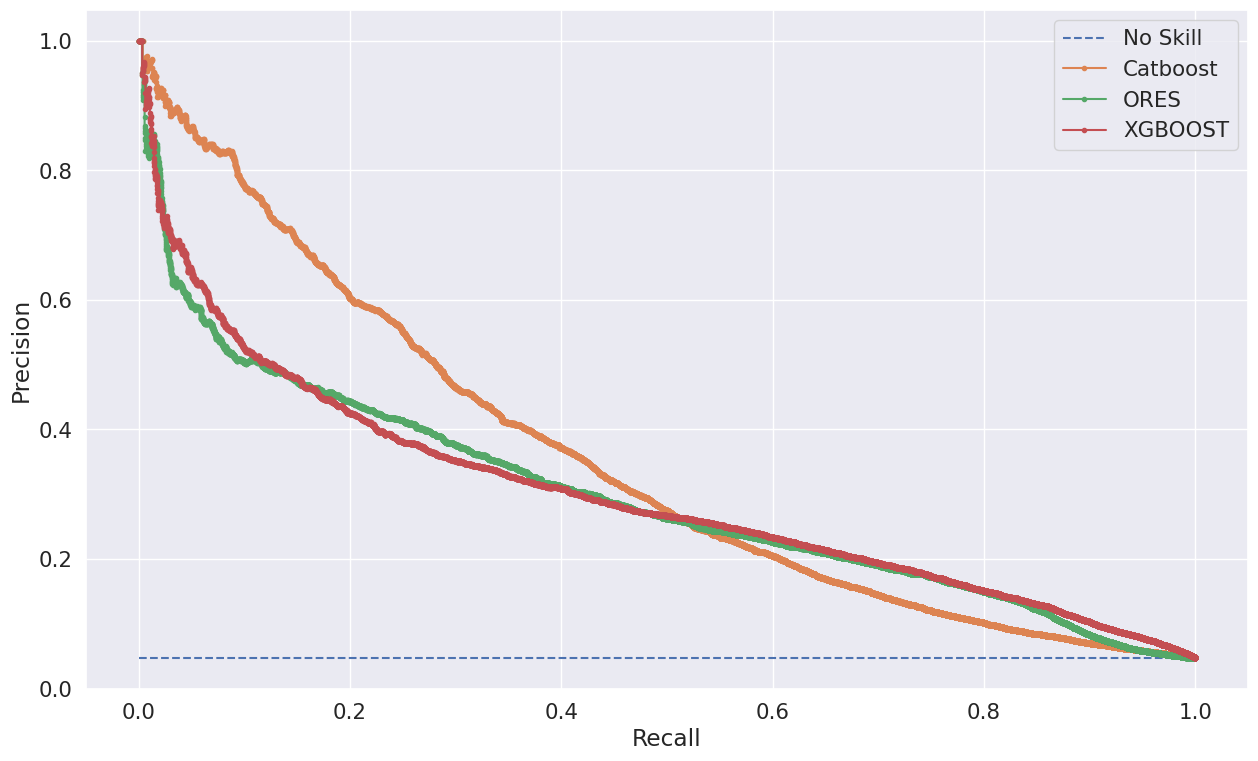

In [51]:
figure(figsize=(15, 9), dpi=100)
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
precision_recall_plot(df_to_plot)

In [69]:
# if treshold is 0.95:
# results interpretation: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.catboost_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.catboost_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.catboost_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.333314001256585
Recall:  0.5498891706134685
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  103455
Number of items predicted as revert and are really reverts:  34483
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.37319824399813395
Recall:  0.4975202921430736
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  83599
Number of items predicted as revert and are really reverts:  31199
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.41672759829888834
Recall:  0.4453427737645314
Total number of r

In [70]:
# if treshold is 0.95:
# results interpretation: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.xgb_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.xgb_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.xgb_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.20947572101353673
Recall:  0.8355578944011226
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  250134
Number of items predicted as revert and are really reverts:  52397
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.22530522136616327
Recall:  0.8072206541325806
Total number of revisions:  786024
Total number of reverts:  62709
Number of items predicted as revert (should be reviewed):  224673
Number of items predicted as revert and are really reverts:  50620
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.2399209894013768
Recall:  0.7786442137492225
Total number of

Random model: ROC AUC=0.498
Catboost: ROC AUC=0.811
ORES model: ROC AUC=0.815
xgboost: ROC AUC=0.844
__________________________________________________
Catboost: f1=0.667 auc=0.831
ORES: f1=0.577 auc=0.816
XGBOOST: f1=0.789 auc=0.830


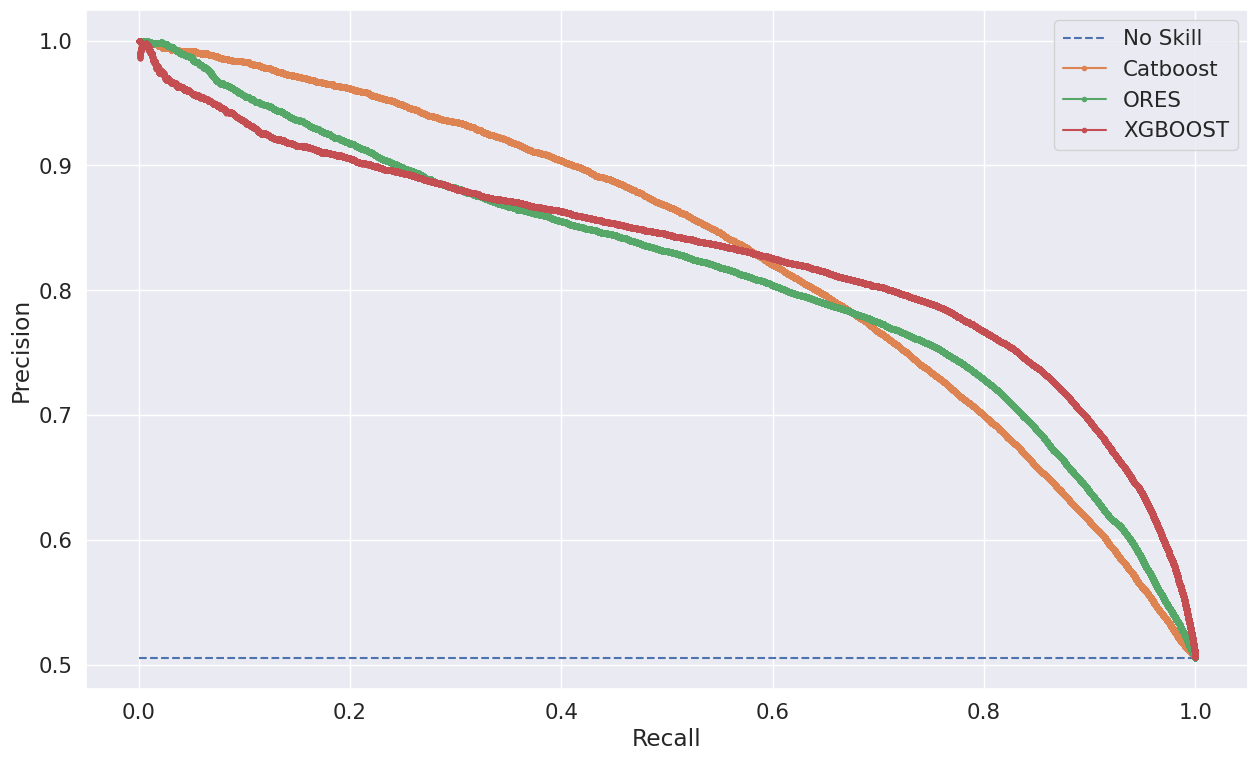

In [64]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.is_balanced == 1)]
figure(figsize=(15, 9), dpi=100)
precision_recall_plot(df_to_plot)

ukwiki
Random model: ROC AUC=0.511
Catboost: ROC AUC=0.842
ORES model: ROC AUC=0.862
xgboost: ROC AUC=0.876
__________________________________________________
Catboost: f1=0.371 auc=0.368
ORES: f1=0.298 auc=0.259
XGBOOST: f1=0.247 auc=0.306


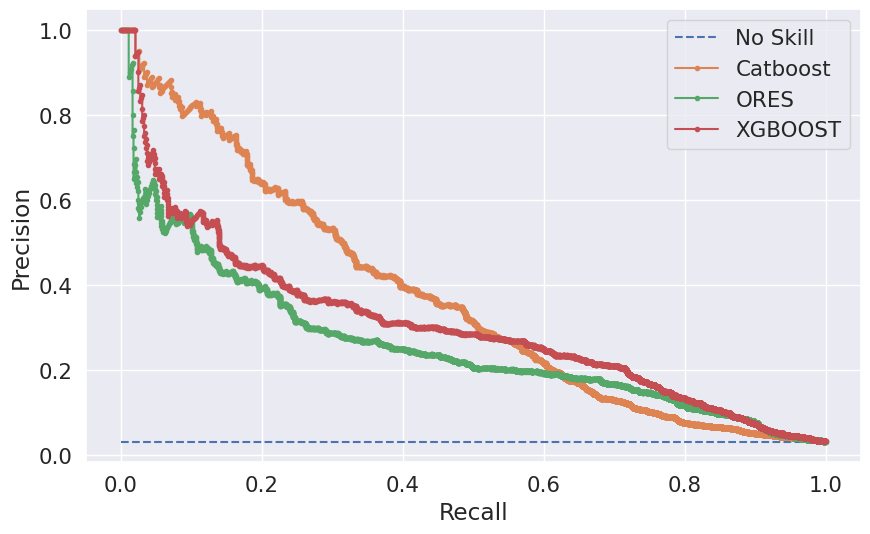

dewiki
Random model: ROC AUC=0.499
Catboost: ROC AUC=0.828
ORES model: ROC AUC=0.856
xgboost: ROC AUC=0.867
__________________________________________________
Catboost: f1=0.418 auc=0.422
ORES: f1=0.364 auc=0.319
XGBOOST: f1=0.311 auc=0.320


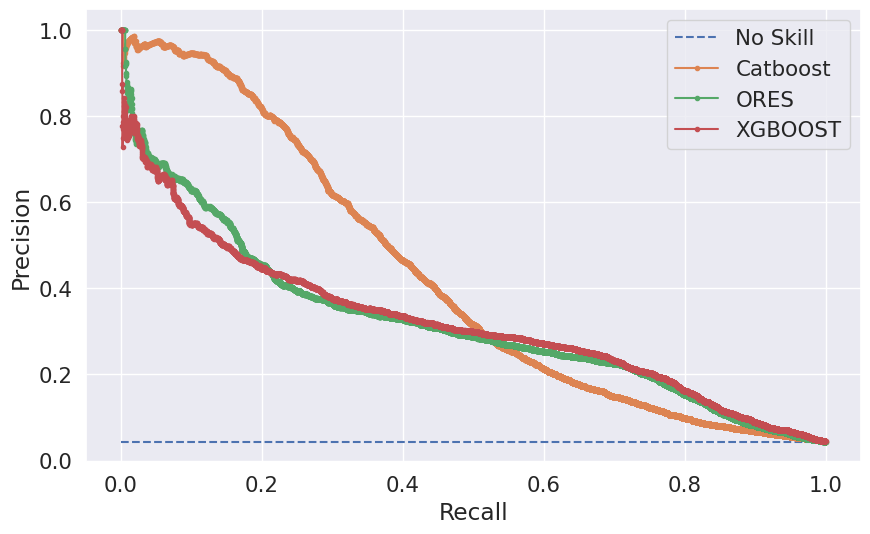

plwiki
Random model: ROC AUC=0.507
Catboost: ROC AUC=0.801
ORES model: ROC AUC=0.835
xgboost: ROC AUC=0.887
__________________________________________________
Catboost: f1=0.342 auc=0.345
ORES: f1=0.276 auc=0.314
XGBOOST: f1=0.351 auc=0.339


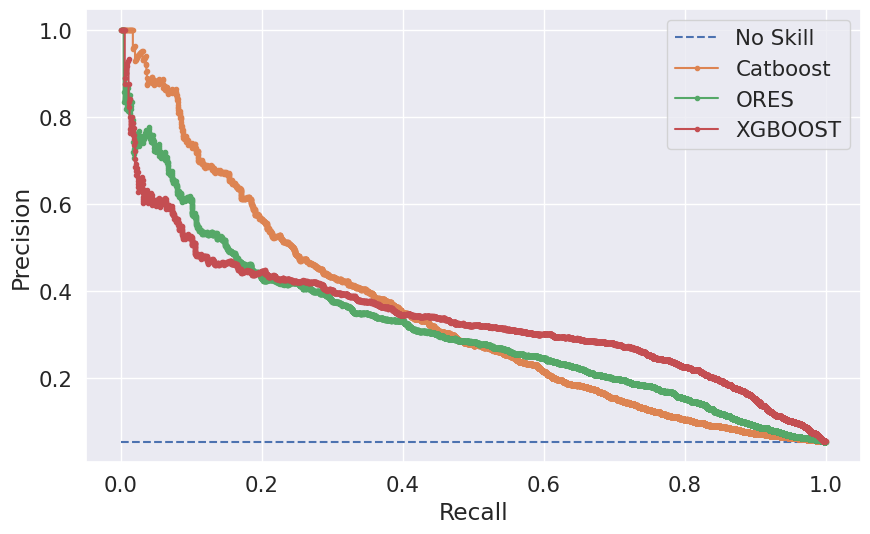

eswiki
Random model: ROC AUC=0.498
Catboost: ROC AUC=0.835
ORES model: ROC AUC=0.873
xgboost: ROC AUC=0.866
__________________________________________________
Catboost: f1=0.501 auc=0.555
ORES: f1=0.494 auc=0.631
XGBOOST: f1=0.447 auc=0.500


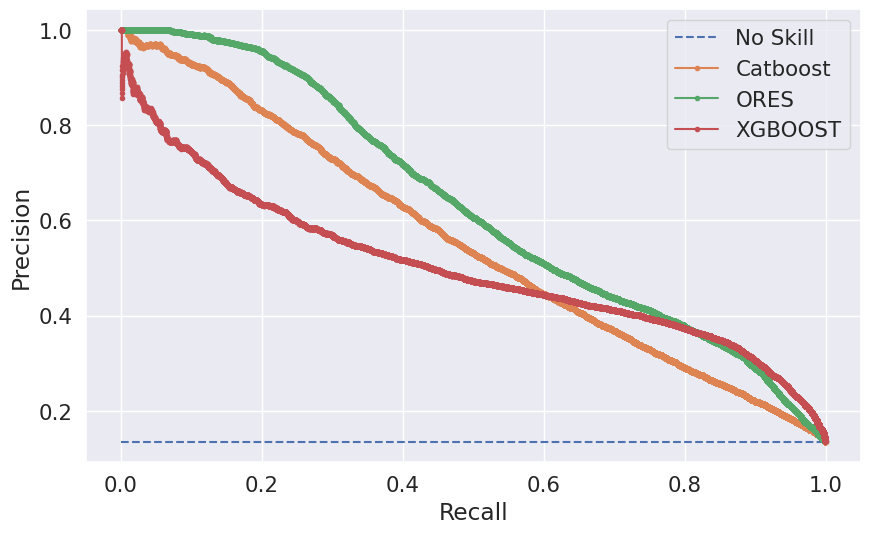

ruwiki
Random model: ROC AUC=0.507
Catboost: ROC AUC=0.831
ORES model: ROC AUC=0.854
xgboost: ROC AUC=0.858
__________________________________________________
Catboost: f1=0.474 auc=0.510
ORES: f1=0.433 auc=0.472
XGBOOST: f1=0.377 auc=0.456


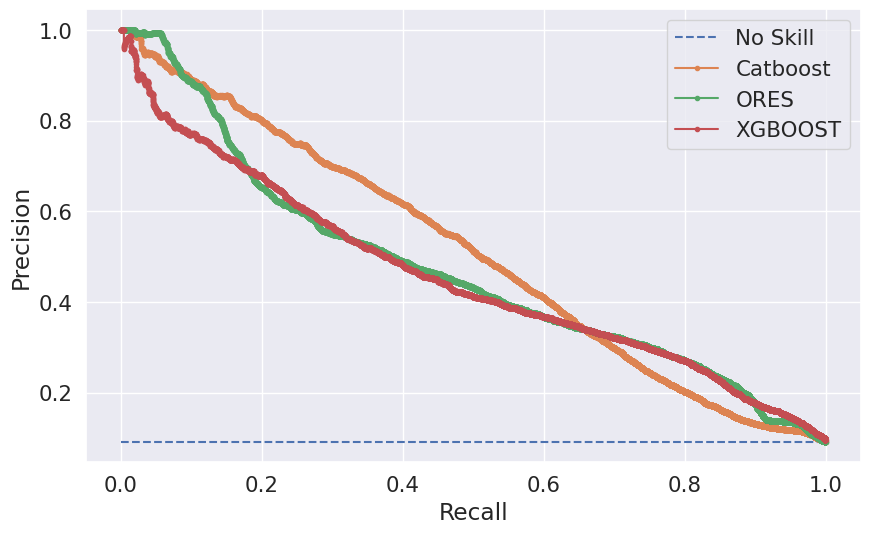

enwiki
Random model: ROC AUC=0.500
Catboost: ROC AUC=0.814
ORES model: ROC AUC=0.816
xgboost: ROC AUC=0.836
__________________________________________________
Catboost: f1=0.393 auc=0.397
ORES: f1=0.354 auc=0.358
XGBOOST: f1=0.315 auc=0.317


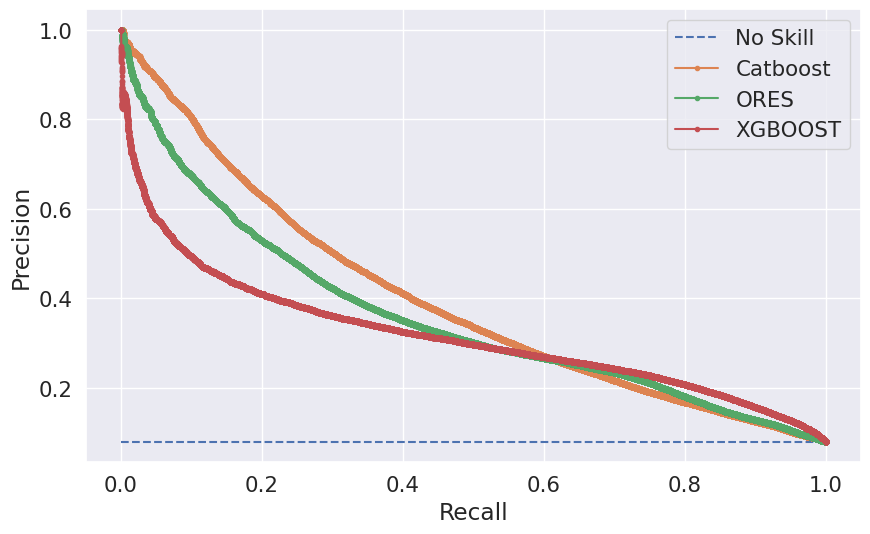

In [65]:
for wiki_db in test_df.wiki_db.unique():
    print(wiki_db)
    df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == wiki_db)]
    figure(figsize=(10, 6), dpi=100)
    precision_recall_plot(df_to_plot)

In [71]:
# results interpretation for ukwiki: 
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == "ukwiki")]
true_values = df_to_plot[target_column].values
catboost_probs = df_to_plot.catboost_pred.values
catboost_auc = roc_auc_score(true_values, catboost_probs)
catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)

for threshold in range(50, 100, 5):
    threshold = threshold/100
    index = np.where(catboost_tresh > threshold)[0][0]

    print("Threshold: ", threshold)
    print("_"*50)
    print("Precision: ", catboost_precision[index])
    print("Recall: ", catboost_recall[index])

    print("Total number of revisions: ", len(df_to_plot))
    print("Total number of reverts: ", (df_to_plot[target_column]==1).sum())
    print("Number of items predicted as revert (should be reviewed): ", (df_to_plot.catboost_pred>threshold).sum())
    print("Number of items predicted as revert and are really reverts: ", ((df_to_plot.catboost_pred>threshold) & df_to_plot[target_column]==1).sum())
    print("-"*50)
    print("-"*50)

Threshold:  0.5
__________________________________________________
Precision:  0.5421052631578948
Recall:  0.2821917808219178
Total number of revisions:  22623
Total number of reverts:  730
Number of items predicted as revert (should be reviewed):  380
Number of items predicted as revert and are really reverts:  206
--------------------------------------------------
--------------------------------------------------
Threshold:  0.55
__________________________________________________
Precision:  0.5961538461538461
Recall:  0.2547945205479452
Total number of revisions:  22623
Total number of reverts:  730
Number of items predicted as revert (should be reviewed):  312
Number of items predicted as revert and are really reverts:  186
--------------------------------------------------
--------------------------------------------------
Threshold:  0.6
__________________________________________________
Precision:  0.6234817813765182
Recall:  0.21095890410958903
Total number of revisions:  2262

# 6. Calculate metrics for each day, look how they differ

In [72]:
from sklearn.metrics import roc_auc_score

df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]

def get_time_characteristics(df_to_plot):
    
    df_to_plot["day"] = pd.to_datetime(df_to_plot.event_timestamp).dt.day
    
    def compute_accuracy_catboost(df):
        pred = (df.catboost_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_accuracy_ores(df):
        pred = (df.ores_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_accuracy_xgb(df):
        pred = (df.xgb_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return (pred == true).mean()

    def compute_auc_catboost(df):
        score = df.catboost_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_ores(df):
        score = df.ores_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_xgboost(df):
        score = df.xgb_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    cat_acc = df_to_plot.groupby("day").apply(compute_accuracy_catboost)
    ore_acc = df_to_plot.groupby("day").apply(compute_accuracy_ores)
    xgb_acc = df_to_plot.groupby("day").apply(compute_accuracy_xgb)
    cat_auc = df_to_plot.groupby("day").apply(compute_auc_catboost)
    ore_auc = df_to_plot.groupby("day").apply(compute_auc_ores)
    xgb_auc = df_to_plot.groupby("day").apply(compute_auc_xgboost)

    final_df = pd.concat([cat_acc, ore_acc, xgb_acc, cat_auc, ore_auc, xgb_auc], axis = 1)
    final_df.columns = ["accuracy_catboost", "accuracy_ores", "accuracy_xgb", "auc_catboost", "auc_ores", "auc_xgb"]
    
    return final_df

In [73]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
get_time_characteristics(df_to_plot)

,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.877181,0.892006,0.733006,0.825808,0.827609,0.848010
2,0.876377,0.892849,0.734877,0.827283,0.829712,0.857750
3,0.882666,0.899464,0.751982,0.824258,0.834425,0.859248
4,0.879028,0.892497,0.741536,0.818391,0.820973,0.844531
5,0.872676,0.891512,0.724351,0.813590,0.828552,0.844826
6,0.875099,0.891124,0.730488,0.824790,0.823773,0.853902
7,0.871208,0.890775,0.730659,0.828058,0.825249,0.852592


In [75]:
import warnings
warnings.filterwarnings("ignore")

for wikidb in test_df.wiki_db.unique():
    print(wikidb)
    df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1) & (test_df.wiki_db == wiki_db)]
    display(get_time_characteristics(df_to_plot))

ukwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


dewiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


plwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


eswiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


ruwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


enwiki


,accuracy_catboost,accuracy_ores,accuracy_xgb,auc_catboost,auc_ores,auc_xgb
day,,,,,,
1,0.869828,0.912437,0.715032,0.822567,0.818144,0.834397
2,0.868679,0.910392,0.710065,0.819237,0.820135,0.843183
3,0.874255,0.915962,0.732035,0.811680,0.827545,0.842999
4,0.872578,0.911667,0.724384,0.813100,0.816328,0.838321
5,0.862102,0.908317,0.700153,0.805240,0.816223,0.829272
6,0.861630,0.906173,0.703199,0.809818,0.807877,0.835024
7,0.856972,0.902682,0.699128,0.812105,0.805556,0.827849


# How model predictions differ

In [220]:
def get_grouped_characteristics(df_to_plot, column="text_changes_found"):
    
    def compute_accuracy_catboost(df):
        pred = (df.catboost_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_accuracy_ores(df):
        pred = (df.ores_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_accuracy_xgb(df):
        pred = (df.xgb_pred > 0.5).astype(int)
        true = df.revision_is_identity_reverted
        return f1_score(true, pred)

    def compute_auc_catboost(df):
        score = df.catboost_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_ores(df):
        score = df.ores_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    def compute_auc_xgboost(df):
        score = df.xgb_pred.fillna(-1)
        true = df.revision_is_identity_reverted
        return roc_auc_score(true, score)

    cat_acc = df_to_plot.groupby(column).apply(compute_accuracy_catboost)
    ore_acc = df_to_plot.groupby(column).apply(compute_accuracy_ores)
    xgb_acc = df_to_plot.groupby(column).apply(compute_accuracy_xgb)
    cat_auc = df_to_plot.groupby(column).apply(compute_auc_catboost)
    ore_auc = df_to_plot.groupby(column).apply(compute_auc_ores)
    xgb_auc = df_to_plot.groupby(column).apply(compute_auc_xgboost)
    count_ = df_to_plot.groupby(column)["comment_p_1"].count()

    final_df = pd.concat([cat_acc, ore_acc, xgb_acc, cat_auc, ore_auc, xgb_auc, count_], axis = 1)
    final_df.columns = ["f1_catboost", "f1_ores", "f1_xgb", "auc_catboost", "auc_ores", "auc_xgb", "samples_count"]
    
    return final_df

In [221]:
df_to_plot = test_df[(test_df.xgb_pred != -1) & (test_df.catboost_pred != -1) & (test_df.ores_pred != -1)]
df_to_plot[["ores_pred", "catboost_pred", "xgb_pred"]].corr()

,ores_pred,catboost_pred,xgb_pred
ores_pred,1.000000,0.517035,0.682080
catboost_pred,0.517035,1.000000,0.627236
xgb_pred,0.682080,0.627236,1.000000


In [178]:
threshold = 0.5
df_to_plot["catboost_correct"] = (df_to_plot.catboost_pred > threshold).astype(int) == df_to_plot[target_column]
df_to_plot["xgb_correct"] = (df_to_plot.xgb_pred > threshold).astype(int) == df_to_plot[target_column]
df_to_plot["ores_correct"] = (df_to_plot.ores_pred > threshold).astype(int) == df_to_plot[target_column]

In [179]:
print("rate where all are the same")
((df_to_plot.catboost_correct == df_to_plot.xgb_correct) == df_to_plot.ores_correct).mean()

rate where all are the same


0.7726786968336845

In [180]:
print("rate where all are the same and correct")
(df_to_plot.catboost_correct & df_to_plot.xgb_correct & df_to_plot.ores_correct).mean()

rate where all are the same and correct


0.6702263544115701

In [181]:
print("rate where at least one is correct")
(df_to_plot.catboost_correct | df_to_plot.xgb_correct | df_to_plot.ores_correct).mean()

rate where at least one is correct


0.9683966392883678

In [182]:
print("Model performance in case of text differences")
get_grouped_characteristics(df_to_plot, column="text_changes_found")

Model performance in case of text differences


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
text_changes_found,,,,,,,
False,0.369653,0.350030,0.312935,0.808319,0.825295,0.854082,367414
True,0.442624,0.418167,0.348175,0.829019,0.823510,0.844398,418610


In [184]:
df_to_plot["is_text_insert"] = df_to_plot.insert_s_0_max != -1
df_to_plot["is_text_change"] = df_to_plot.change_s_0_max != -1
df_to_plot["is_comment_exist"] = ~df_to_plot.event_comment.isna()

print("Model performance in case of text inserted")
display(get_grouped_characteristics(df_to_plot, column="is_text_insert"))

print("Model performance in case of text changed")
display(get_grouped_characteristics(df_to_plot, column="is_text_change"))

print("Model performance in case of comment exist")
display(get_grouped_characteristics(df_to_plot, column="is_comment_exist"))

Model performance in case of text inserted


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_text_insert,,,,,,,
False,0.388691,0.366182,0.313584,0.812041,0.827051,0.849219,613888
True,0.477915,0.469332,0.397022,0.845933,0.830585,0.855160,172136


Model performance in case of text changed


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_text_change,,,,,,,
False,0.40155,0.388741,0.340032,0.818907,0.825481,0.854545,494281
True,0.43591,0.402677,0.328226,0.829084,0.830288,0.845486,291743


Model performance in case of comment exist


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_comment_exist,,,,,,,
False,0.485582,0.470278,0.400097,0.833195,0.825647,0.837255,188381
True,0.353746,0.339382,0.292162,0.796537,0.806203,0.839586,597643


In [186]:
df_to_plot['quantiles page_revision_count'] = pd.qcut(
    df_to_plot['page_revision_count'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of page_revision_count")
display(get_grouped_characteristics(df_to_plot, column="quantiles page_revision_count"))


Model performance for quantiles of page_revision_count


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles page_revision_count,,,,,,,
12,0.270841,0.213018,0.226797,0.765395,0.780524,0.854630,70335
11,0.306925,0.264527,0.244298,0.778948,0.811301,0.849242,65531
10,0.322148,0.305607,0.246422,0.790939,0.842021,0.855570,62314
9,0.342105,0.316401,0.273747,0.791609,0.839683,0.854144,66291
8,0.370927,0.320821,0.280822,0.783979,0.822739,0.831918,64692
7,0.379552,0.345966,0.296307,0.786406,0.816087,0.827924,64304
6,0.399572,0.360751,0.318209,0.790214,0.813312,0.825265,65813
5,0.423135,0.410495,0.336615,0.802327,0.822211,0.827134,64884
4,0.419291,0.413664,0.351576,0.789300,0.809484,0.817804,65361


In [192]:
df_to_plot['quantiles event_user_seconds_since_previous_revision'] = pd.qcut(
    df_to_plot['event_user_seconds_since_previous_revision'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of event_user_seconds_since_previous_revision")
display(get_grouped_characteristics(df_to_plot, column="quantiles event_user_seconds_since_previous_revision"))


df_to_plot['is_event_user_seconds_since_previous_revision'] = ~df_to_plot['event_user_seconds_since_previous_revision'].isna()

print("Model performance for event_user_seconds_since_previous_revision isna")
display(get_grouped_characteristics(df_to_plot, column="is_event_user_seconds_since_previous_revision"))

Model performance for quantiles of event_user_seconds_since_previous_revision


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles event_user_seconds_since_previous_revision,,,,,,,
12,0.037964,0.008021,0.073034,0.608909,0.687851,0.751025,54654
11,0.141599,0.054054,0.167939,0.699078,0.702270,0.807192,52113
10,0.130610,0.093973,0.186259,0.689740,0.730258,0.804640,52182
9,0.149730,0.150858,0.202627,0.705204,0.747676,0.810614,49732
8,0.168022,0.181105,0.208859,0.712718,0.746404,0.808901,52967
7,0.189058,0.184145,0.212722,0.706650,0.744398,0.804208,50911
6,0.189565,0.225510,0.213336,0.719708,0.733913,0.799773,52047
5,0.200370,0.241280,0.218154,0.727021,0.746565,0.798913,52128
4,0.186481,0.203089,0.197573,0.713733,0.725864,0.785269,51995


Model performance for event_user_seconds_since_previous_revision isna


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
is_event_user_seconds_since_previous_revision,,,,,,,
False,0.555646,0.460108,0.414316,0.780453,0.677534,0.660590,161105
True,0.178267,0.164308,0.196764,0.716034,0.727439,0.795011,624919


In [193]:
df_to_plot['quantiles revision_text_bytes_diff'] = pd.qcut(
    df_to_plot['revision_text_bytes_diff'], q=12, labels=[12,11,10,9,8,7,6,5,4,3,2,1]
)
print("Model performance for quantiles of revision_text_bytes_diff")
display(get_grouped_characteristics(df_to_plot, column="quantiles revision_text_bytes_diff"))


Model performance for quantiles of revision_text_bytes_diff


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
quantiles revision_text_bytes_diff,,,,,,,
12,0.422792,0.505187,0.363212,0.839922,0.864681,0.879629,65894
11,0.368173,0.330354,0.286279,0.805388,0.830333,0.849036,66045
10,0.406342,0.383545,0.322807,0.815692,0.831948,0.842624,65174
9,0.370598,0.315298,0.294535,0.796242,0.802417,0.824779,106164
8,0.401562,0.322158,0.317738,0.813676,0.807570,0.834405,27300
7,0.434876,0.413018,0.351756,0.827021,0.844307,0.853940,66851
6,0.456096,0.451103,0.385448,0.847358,0.861599,0.867874,63888
5,0.441920,0.427914,0.363077,0.831833,0.850942,0.860085,65762
4,0.460196,0.419154,0.359225,0.850947,0.839326,0.863434,64018


In [195]:
most_freq = df_to_plot.country_iso_code.value_counts().index[:10]

print("Model performance for country_iso_code")
display(get_grouped_characteristics(df_to_plot[df_to_plot.country_iso_code.isin(most_freq)], column="country_iso_code"))

Model performance for country_iso_code


,f1_catboost,f1_ores,f1_xgb,auc_catboost,auc_ores,auc_xgb,samples_count
country_iso_code,,,,,,,
AR,0.627027,0.522749,0.493852,0.797172,0.761249,0.663115,3761
AU,0.463017,0.423227,0.346415,0.748830,0.674097,0.657072,3819
CA,0.557292,0.393683,0.355343,0.810897,0.636022,0.651206,5348
DE,0.555091,0.401736,0.362448,0.805292,0.672152,0.660242,9321
ES,0.584730,0.498983,0.470712,0.778463,0.730979,0.687332,5985
GB,0.569163,0.492061,0.427276,0.790255,0.697042,0.668103,13332
IN,0.529119,0.483291,0.440862,0.763827,0.691210,0.664997,8819
MX,0.672211,0.616845,0.543510,0.819543,0.779409,0.687559,4068
RU,0.623747,0.444925,0.424191,0.838974,0.698972,0.710716,10513


# Attempt to build a meta-model:

In [222]:
features_to_use = [
 'wiki_db',
 'page_revision_count',
 'revision_text_bytes_diff',
 # 'revision_is_identity_reverted',
 'is_mobile_edit',
 'is_mobile_web_edit',
 'is_visualeditor',
 'is_wikieditor',
 'is_mobile_app_editandroid_app_edit',
 'is_ios_app_edit',
 'Argument_change',
 'Argument_insert',
 'Argument_move',
 'Argument_remove',
 'Category_change',
 'Category_insert',
 'Category_move',
 'Category_remove',
 'Comment_change',
 'Comment_insert',
 'Comment_move',
 'Comment_remove',
 'ExternalLink_change',
 'ExternalLink_insert',
 'ExternalLink_move',
 'ExternalLink_remove',
 'Gallery_change',
 'Gallery_insert',
 'Gallery_move',
 'Gallery_remove',
 'HTMLEntity_change',
 'HTMLEntity_insert',
 'HTMLEntity_move',
 'HTMLEntity_remove',
 'Heading_change',
 'Heading_insert',
 'Heading_move',
 'Heading_remove',
 'List_change',
 'List_insert',
 'List_move',
 'List_remove',
 'Media_change',
 'Media_insert',
 'Media_move',
 'Media_remove',
 'Paragraph_change',
 'Paragraph_insert',
 'Paragraph_move',
 'Paragraph_remove',
 'Punctuation_change',
 'Punctuation_insert',
 'Punctuation_move',
 'Punctuation_remove',
 'Reference_change',
 'Reference_insert',
 'Reference_move',
 'Reference_remove',
 'Section_change',
 'Section_insert',
 'Section_move',
 'Section_remove',
 'Sentence_change',
 'Sentence_insert',
 'Sentence_move',
 'Sentence_remove',
 'Table_change',
 'Table_insert',
 'Table_move',
 'Table_remove',
 'Table Element_change',
 'Table Element_insert',
 'Table Element_move',
 'Table Element_remove',
 'Template_change',
 'Template_insert',
 'Template_move',
 'Template_remove',
 'Text_change',
 'Text_insert',
 'Text_move',
 'Text_remove',
 'Text Formatting_change',
 'Text Formatting_insert',
 'Text Formatting_move',
 'Text Formatting_remove',
 'Whitespace_change',
 'Whitespace_insert',
 'Whitespace_move',
 'Whitespace_remove',
 'Wikilink_change',
 'Wikilink_insert',
 'Wikilink_move',
 'Wikilink_remove',
 'Word_change',
 'Word_insert',
 'Word_move',
 'Word_remove',
 'insert_s_0_max',
 'insert_s_1_max',
 'insert_p_0_max',
 'insert_p_1_max',
 'insert_s_0_mean',
 'insert_s_1_mean',
 'insert_p_0_mean',
 'insert_p_1_mean',
 'change_s_0_max',
 'change_s_1_max',
 'change_p_0_max',
 'change_p_1_max',
 'change_s_0_mean',
 'change_s_1_mean',
 'change_p_0_mean',
 'change_p_1_mean',
 'title_s_0',
 'title_p_0',
 'comment_s_0',
 'comment_s_1',
 'comment_p_0',
 'comment_p_1',
 'catboost_pred',
 # 'ores_pred',
 'xgb_pred']

target = 'revision_is_identity_reverted'



In [223]:
BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True
features = features_to_use

train, test = df_to_plot[df_to_plot.day.isin([1, 2, 3, 4, 5])], df_to_plot[df_to_plot.day.isin([6, 7])]

cat_features = [
    'wiki_db',
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
]

train_data = Pool(
    data=train[features],
    label=train[target],
    cat_features=cat_features
)
test_data = Pool(
    data=test[features],
    label=test[target],
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(train[target])
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=train[target])
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights, 
                           use_best_model=True,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model.best_score_

0:	learn: 0.6879534	test: 0.6879298	best: 0.6879298 (0)	total: 248ms	remaining: 20m 38s
100:	learn: 0.4823942	test: 0.4816577	best: 0.4816577 (100)	total: 16.4s	remaining: 13m 17s
200:	learn: 0.4526702	test: 0.4536852	best: 0.4536852 (200)	total: 32.8s	remaining: 13m 2s
300:	learn: 0.4435858	test: 0.4463690	best: 0.4463690 (300)	total: 48.8s	remaining: 12m 41s
400:	learn: 0.4392178	test: 0.4435509	best: 0.4435509 (400)	total: 1m 4s	remaining: 12m 24s
500:	learn: 0.4365225	test: 0.4421790	best: 0.4421790 (500)	total: 1m 20s	remaining: 12m 4s
600:	learn: 0.4345327	test: 0.4411126	best: 0.4411126 (600)	total: 1m 36s	remaining: 11m 43s
700:	learn: 0.4329772	test: 0.4402788	best: 0.4402788 (700)	total: 1m 51s	remaining: 11m 24s
800:	learn: 0.4315776	test: 0.4396273	best: 0.4396273 (800)	total: 2m 7s	remaining: 11m 7s
900:	learn: 0.4303338	test: 0.4390262	best: 0.4390262 (900)	total: 2m 22s	remaining: 10m 47s
1000:	learn: 0.4292405	test: 0.4385884	best: 0.4385884 (1000)	total: 2m 37s	remaini

{'learn': {'Accuracy:use_weights=false': 0.8131694528252824,
  'Precision:use_weights=false': 0.27349860205032617,
  'Recall:use_weights=false': 0.8310602628001812,
  'Logloss:use_weights=true': 0.39838898258038385,
  'Accuracy:use_weights=true': 0.8213516057647261,
  'Logloss:use_weights=false': 0.40309278136776056,
  'Logloss': 0.39838898258038385,
  'Precision:use_weights=true': 0.8152306754693336,
  'Recall:use_weights=true': 0.8310602628001812,
  'F1:use_weights=false': 0.4115558298039435,
  'F1:use_weights=true': 0.8230693659900337},
 'validation': {'Accuracy:use_weights=false': 0.8019798893826985,
  'Recall:use_weights=false': 0.8447950885885077,
  'Precision:use_weights=false': 0.2674055180342003,
  'Logloss:use_weights=true': 0.43420882950411077,
  'Accuracy:use_weights=true': 0.8019484946453385,
  'AUC': 0.8809137261488611,
  'Logloss:use_weights=false': 0.4229159521308702,
  'Logloss': 0.43420882950411077,
  'Precision:use_weights=true': 0.8105335601789956,
  'Recall:use_wei

In [224]:
test["meta_pred"] = model.predict_proba(test_data)[:, 1]
df_to_plot = test

print("Catboost model accuracy: ", ((df_to_plot.catboost_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Xgboost model accuracy: ", ((df_to_plot.xgb_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("ORES model accuracy: ", ((df_to_plot.ores_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())
print("Meta model accuracy: ", ((df_to_plot.meta_pred > 0.5).astype(int) == df_to_plot.revision_is_identity_reverted).mean())

print("-"*50)
print("Catboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred))
print("Xgboost model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred))
print("ORES model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred))
print("Meta model AUC: ", roc_auc_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_pred))

print("-"*50)
print("Catboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.catboost_pred > threshold))
print("Xgboost model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.xgb_pred > threshold))
print("ORES model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.ores_pred > threshold))
print("Meta model F1: ", f1_score(df_to_plot.revision_is_identity_reverted, df_to_plot.meta_pred > threshold))

Catboost model accuracy:  0.873159718201979
Xgboost model accuracy:  0.7305729477462393
ORES model accuracy:  0.8909502222143054
Meta model accuracy:  0.8019798893826985
--------------------------------------------------
Catboost model AUC:  0.8264339365247122
Xgboost model AUC:  0.8532423236775228
ORES model AUC:  0.8245104444297415
Meta model AUC:  0.8809137261488611
--------------------------------------------------
Catboost model F1:  0.4193896895448152
Xgboost model F1:  0.3421836605997347
ORES model F1:  0.39868382280718984
Meta model F1:  0.40104524454142587


In [217]:
def precision_recall_plot(df_to_plot):
    true_values = df_to_plot[target_column].values

    catboost_probs = df_to_plot.catboost_pred.values
    ores_probs = df_to_plot.ores_pred.fillna(0).values
    xgboost_probs = df_to_plot.xgb_pred.fillna(0).values
    meta_probs = df_to_plot.meta_pred.fillna(0).values
    random_probs = [np.random.uniform() for _ in range(len(true_values))]

    # calculate scores
    random_auc = roc_auc_score(true_values, random_probs)
    catboost_auc = roc_auc_score(true_values, catboost_probs)
    ores_auc = roc_auc_score(true_values, ores_probs)
    xgboost_auc = roc_auc_score(true_values, xgboost_probs)
    meta_auc = roc_auc_score(true_values, meta_probs)

    # summarize scores
    print('Random model: ROC AUC=%.3f' % (random_auc))
    print('Catboost: ROC AUC=%.3f' % (catboost_auc))
    print('ORES model: ROC AUC=%.3f' % (ores_auc))
    print('xgboost: ROC AUC=%.3f' % (xgboost_auc))
    print('meta: ROC AUC=%.3f' % (meta_auc))


    # # predict class values
    # yhat = model.predict(hold_out_data)

    catboost_precision, catboost_recall, catboost_tresh = precision_recall_curve(true_values, catboost_probs)
    catboost_f1, catboost_auc = f1_score(true_values, catboost_probs>0.5), auc(catboost_recall, catboost_precision)

    ores_precision, ores_recall, _ = precision_recall_curve(true_values, ores_probs)
    ores_f1, ores_auc = f1_score(true_values, ores_probs>0.5), auc(ores_recall, ores_precision)

    xgboost_precision, xgboost_recall, _ = precision_recall_curve(true_values, xgboost_probs)
    xgboost_f1, xgboost_auc = f1_score(true_values, xgboost_probs>0.5), auc(xgboost_recall, xgboost_precision)
    
    meta_precision, meta_recall, _ = precision_recall_curve(true_values, meta_probs)
    meta_f1, meta_auc = f1_score(true_values, meta_probs>0.5), auc(meta_recall, meta_precision)

    print("_"*50)
    # summarize scores
    print('Catboost: f1=%.3f auc=%.3f' % (catboost_f1, catboost_auc))
    print('ORES: f1=%.3f auc=%.3f' % (ores_f1, ores_auc))
    print('XGBOOST: f1=%.3f auc=%.3f' % (xgboost_f1, xgboost_auc))
    print('META: f1=%.3f auc=%.3f' % (meta_f1, meta_auc))

    # plot the precision-recall curves
    no_skill = len(true_values[true_values==1]) / len(true_values)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(catboost_recall, catboost_precision, marker='.', label='Catboost')
    pyplot.plot(ores_recall, ores_precision, marker='.', label='ORES')
    pyplot.plot(xgboost_recall, xgboost_precision, marker='.', label='XGBOOST')
    pyplot.plot(meta_recall, meta_precision, marker='.', label='META')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

Random model: ROC AUC=0.501
Catboost: ROC AUC=0.826
ORES model: ROC AUC=0.825
xgboost: ROC AUC=0.853
meta: ROC AUC=0.886
__________________________________________________
Catboost: f1=0.419 auc=0.431
ORES: f1=0.399 auc=0.397
XGBOOST: f1=0.342 auc=0.360
META: f1=0.407 auc=0.532


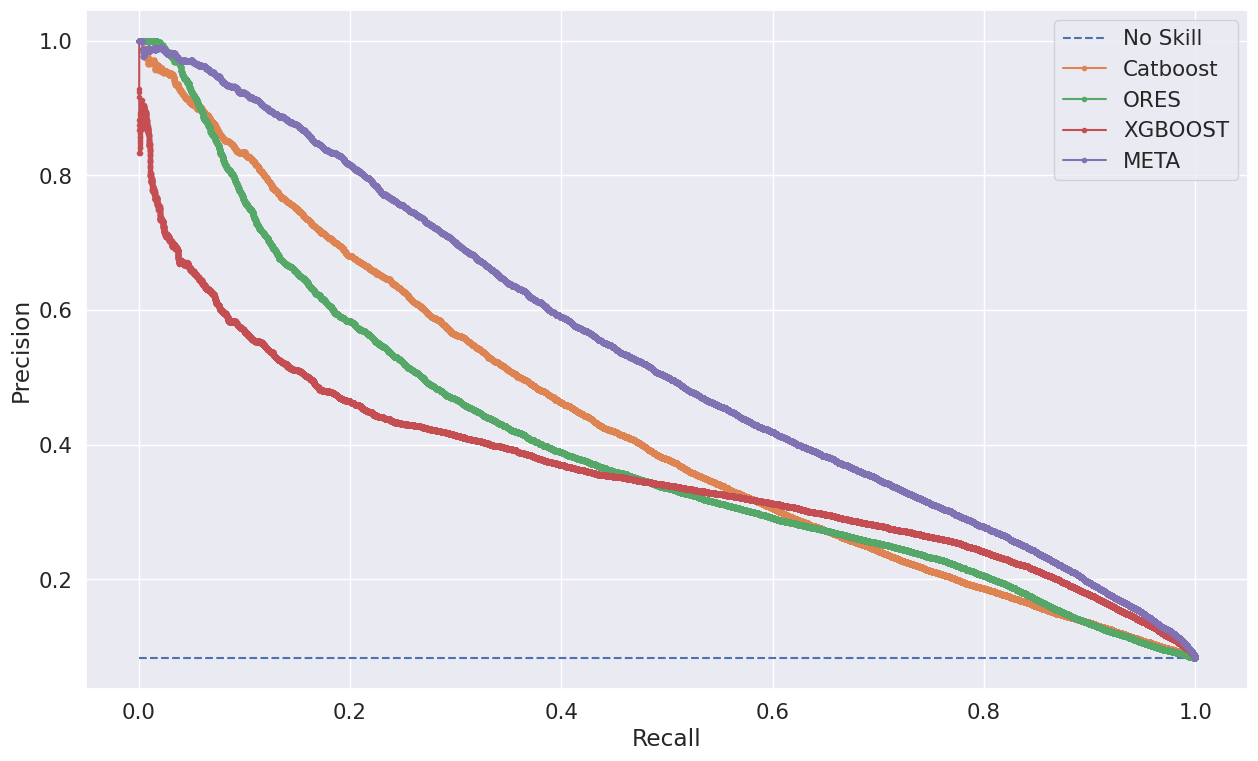

In [211]:
figure(figsize=(15, 9), dpi=100)
precision_recall_plot(test)

In [214]:
pd.DataFrame({'feature_importance': model.get_feature_importance(test_data), 
              'feature_names': features}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(30)

,feature_importance,feature_names
120,17.456427,ores_pred
121,17.407720,xgb_pred
119,15.719107,catboost_pred
1,4.759523,page_revision_count
2,4.275996,revision_text_bytes_diff
0,3.684521,wiki_db
113,3.451492,title_s_0
115,2.290699,comment_s_0
6,1.745951,is_wikieditor
14,1.313411,Category_insert
